In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.gaussian_process as gp
from scipy.integrate import solve_ivp
import scipy.linalg as la

In [3]:
%matplotlib notebook
plt.style.use('seaborn')

In [4]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    # switched to match
    dy[0] = d*y[0]*y[1]-c*y[0]
    dy[1] = a*y[1]-b*y[0]*y[1]
    return dy

def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

In [81]:
# choose true parameters
y0 = [2,.5]
a = 1
b = 1
c = 1
d = 1

# generate simulated data
T_obs = np.linspace(0,10,10)
y = solve_lv(T_obs,y0,a,b,c,d)

# set random seed
np.random.seed(2021)

# add noise
sigma = 0.05*np.max(np.abs(y))
y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))

In [82]:
kernel = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel(sigma**2,noise_level_bounds="fixed")
y_gp = gp.GaussianProcessRegressor(kernel)
y_gp = y_gp.fit(T_obs[:,np.newaxis],y_noisy.T)

In [83]:
T_sur = np.linspace(0,10,200)
y_hr = solve_lv(T_sur,y0,a,b,c,d)

In [84]:
mean,cov = y_gp.predict(T_sur[:,np.newaxis],return_cov=True)

<IPython.core.display.Javascript object>


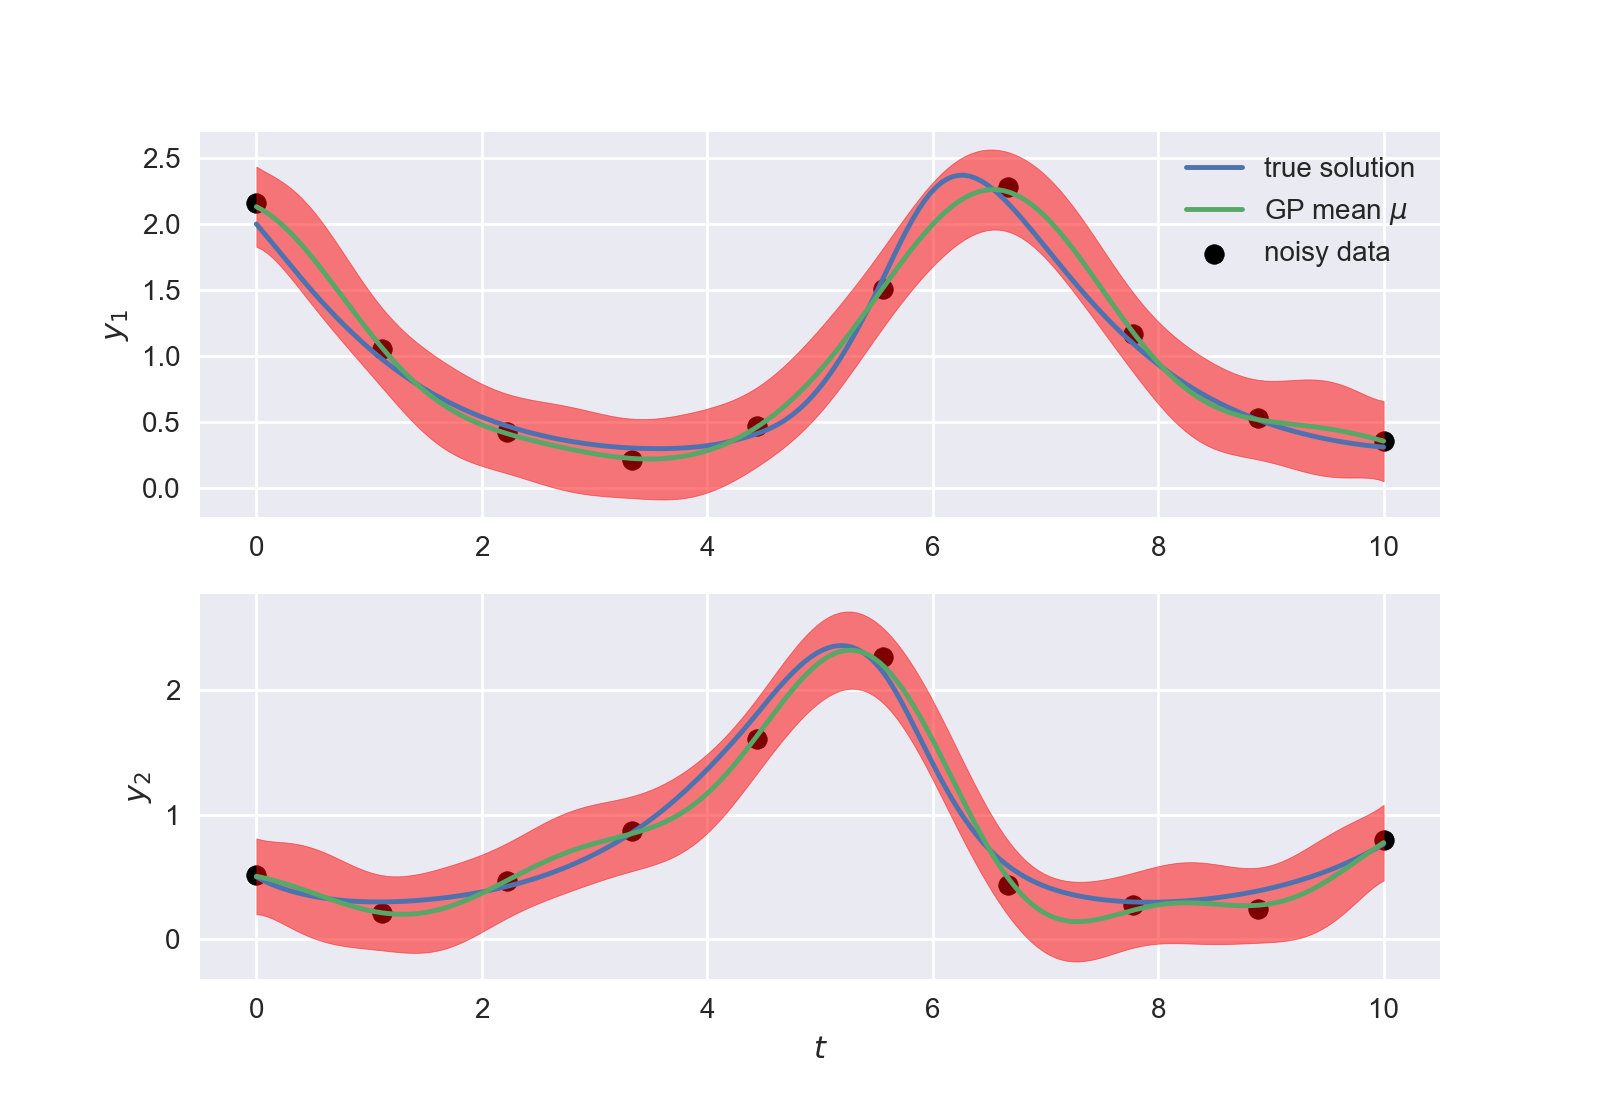

In [85]:
fig = plt.figure()
plt.subplot(211)
plt.ylabel('$y_1$')
plt.plot(T_sur,y_hr[0],label='true solution')
plt.scatter(T,y_noisy[0],c='k',label='noisy data')
plt.plot(T_sur,mean[:,0],label='GP mean $\mu$')
plt.fill_between(T_sur,mean[:,0]-2*np.sqrt(np.diag(cov)),mean[:,0]+2*np.sqrt(np.diag(cov)),color='r',alpha=.5)
plt.legend()
plt.subplot(212)
plt.ylabel('$y_2$')
plt.xlabel('$t$')
plt.plot(T_sur,y_hr[1],label='true')
plt.scatter(T,y_noisy[1],c='k',label='noisy')
plt.plot(T_sur,mean[:,1],label='GP')
plt.fill_between(T_sur,mean[:,1]-2*np.sqrt(np.diag(cov)),mean[:,1]+2*np.sqrt(np.diag(cov)),color='r',alpha=.5)
plt.show()

## Denoising?

In [86]:
# get hyperparams of original gp
tau = y_gp.kernel_.k1.k1.constant_value
length_scale = y_gp.kernel_.k1.k2.length_scale
print(tau,length_scale)

1.0833087283763458 1.1571442937667686


In [87]:
# denoised data: gp mean at T_obs
y_denoised = y_gp.predict(T_obs[:,np.newaxis])

# fit new gp with same params but no white noise term
kernel_denoised = gp.kernels.ConstantKernel(constant_value=tau,
                                          constant_value_bounds='fixed')*gp.kernels.RBF(length_scale=length_scale,
                                                                                        length_scale_bounds='fixed')
y_gp_denoised = gp.GaussianProcessRegressor(kernel_denoised)
y_gp_denoised = y_gp_denoised.fit(T_obs[:,np.newaxis],y_denoised)

In [88]:
mean_denoised,cov_denoised = y_gp_denoised.predict(T_sur[:,np.newaxis],return_cov=True)

In [93]:
# is the denoised data better?
print('Norm of noise error:',la.norm(y-y_noisy,ord='fro'))
print('Norm of denoised error',la.norm(y-y_denoised.T,ord='fro'))

Norm of noise error: 0.42919880953718975
Norm of denoised error 0.3594328896159922


<IPython.core.display.Javascript object>


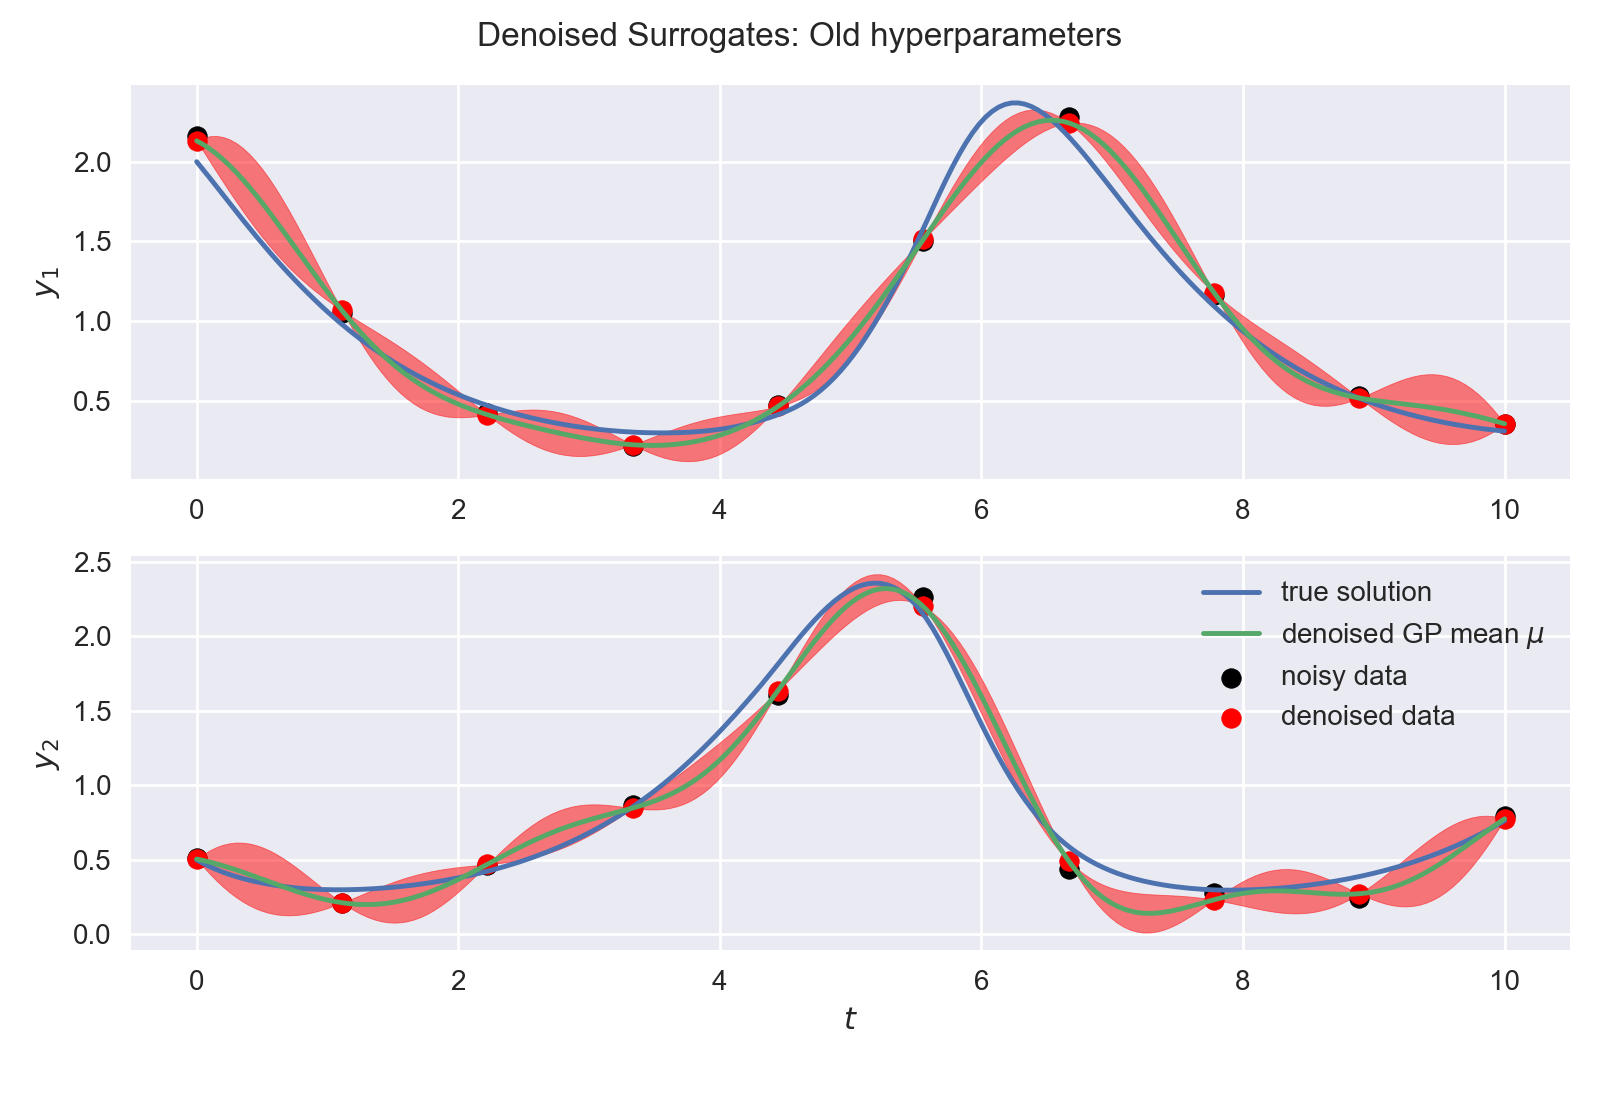

In [100]:
fig = plt.figure()
plt.subplot(211)
plt.ylabel('$y_1$')
plt.plot(T_sur,y_hr[0],label='true solution')
plt.scatter(T,y_noisy[0],c='k',label='noisy data')
plt.scatter(T,y_denoised[:,0],c='r',label='denoised data')
plt.plot(T_sur,mean_denoised[:,0],label='denoised GP mean $\mu$')
plt.fill_between(T_sur,mean_denoised[:,0]-2*np.sqrt(np.diag(cov_denoised)),mean_denoised[:,0]+2*np.sqrt(np.diag(cov_denoised)),color='r',alpha=.5)
# plt.legend()
plt.subplot(212)
plt.ylabel('$y_2$')
plt.xlabel('$t$')
plt.plot(T_sur,y_hr[1],label='true solution')
plt.scatter(T,y_noisy[1],c='k',label='noisy data')
plt.scatter(T,y_denoised[:,1],c='r',label='denoised data')
plt.plot(T_sur,mean_denoised[:,1],label='denoised GP mean $\mu$')
plt.fill_between(T_sur,mean_denoised[:,1]-2*np.sqrt(np.diag(cov_denoised)),mean_denoised[:,1]+2*np.sqrt(np.diag(cov_denoised)),color='r',alpha=.5)
plt.legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Denoised Surrogates: Old hyperparameters')
plt.show()

In [95]:
# try again without old hyperparameters
kernel_denoised2 = gp.kernels.ConstantKernel()*gp.kernels.RBF()
y_gp_denoised2 = gp.GaussianProcessRegressor(kernel_denoised2)
y_gp_denoised2 = y_gp_denoised2.fit(T_obs[:,np.newaxis],y_denoised)

In [96]:
mean_denoised2,cov_denoised2 = y_gp_denoised2.predict(T_sur[:,np.newaxis],return_cov=True)

<IPython.core.display.Javascript object>


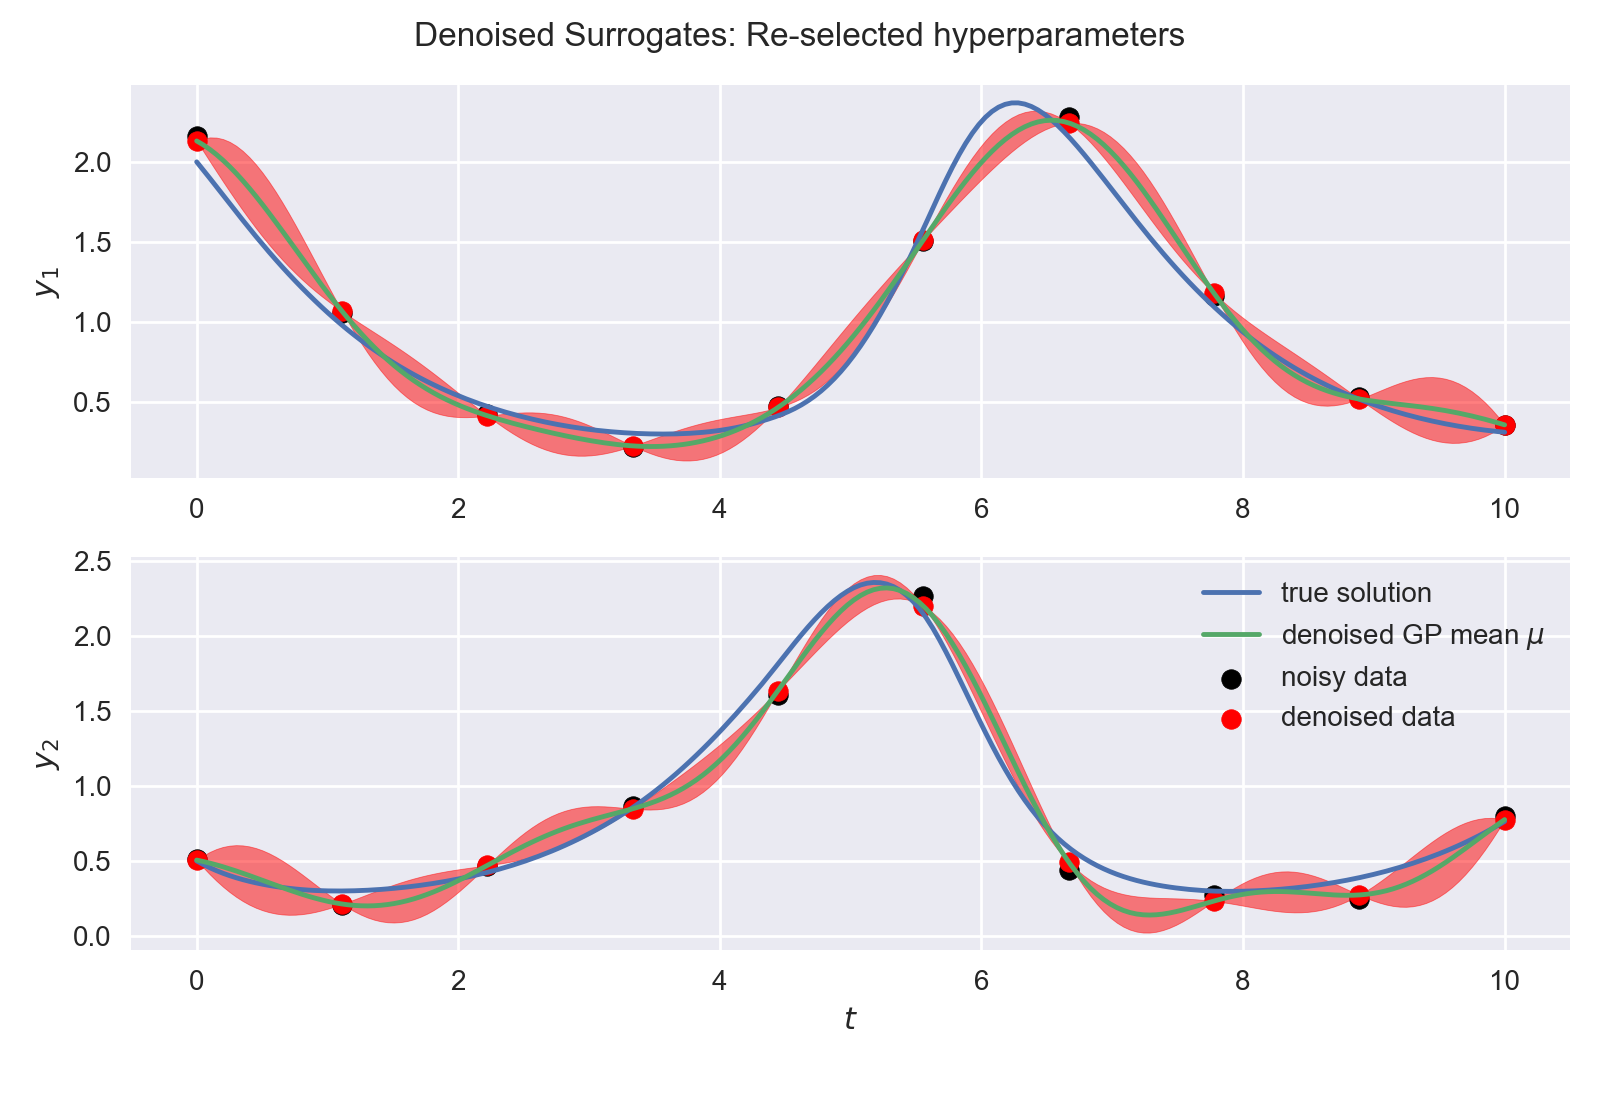

In [101]:
fig = plt.figure()
plt.subplot(211)
plt.ylabel('$y_1$')
plt.plot(T_sur,y_hr[0],label='true solution')
plt.scatter(T,y_noisy[0],c='k',label='noisy data')
plt.scatter(T,y_denoised[:,0],c='r',label='denoised data')
plt.plot(T_sur,mean_denoised2[:,0],label='denoised GP mean $\mu$')
plt.fill_between(T_sur,mean_denoised2[:,0]-2*np.sqrt(np.diag(cov_denoised2)),mean_denoised2[:,0]+2*np.sqrt(np.diag(cov_denoised2)),color='r',alpha=.5)
# plt.legend()
plt.subplot(212)
plt.ylabel('$y_2$')
plt.xlabel('$t$')
plt.plot(T_sur,y_hr[1],label='true solution')
plt.scatter(T,y_noisy[1],c='k',label='noisy data')
plt.scatter(T,y_denoised[:,1],c='r',label='denoised data')
plt.plot(T_sur,mean_denoised2[:,1],label='denoised GP mean $\mu$')
plt.fill_between(T_sur,mean_denoised2[:,1]-2*np.sqrt(np.diag(cov_denoised2)),mean_denoised2[:,1]+2*np.sqrt(np.diag(cov_denoised2)),color='r',alpha=.5)
plt.legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Denoised Surrogates: Re-selected hyperparameters')
plt.show()

In [104]:
# comparison of hyperparameters
print('fixed hyperparameters:',y_gp_denoised.kernel_)
print('updated hyperparameters:',y_gp_denoised2.kernel_)

fixed hyperparameters: 1.04**2 * RBF(length_scale=1.16)
updated hyperparameters: 1.03**2 * RBF(length_scale=1.18)


Updated hyperparameters seem very similar!

In [108]:
samples = y_gp_denoised.sample_y(T_sur[:,np.newaxis],10)

<IPython.core.display.Javascript object>


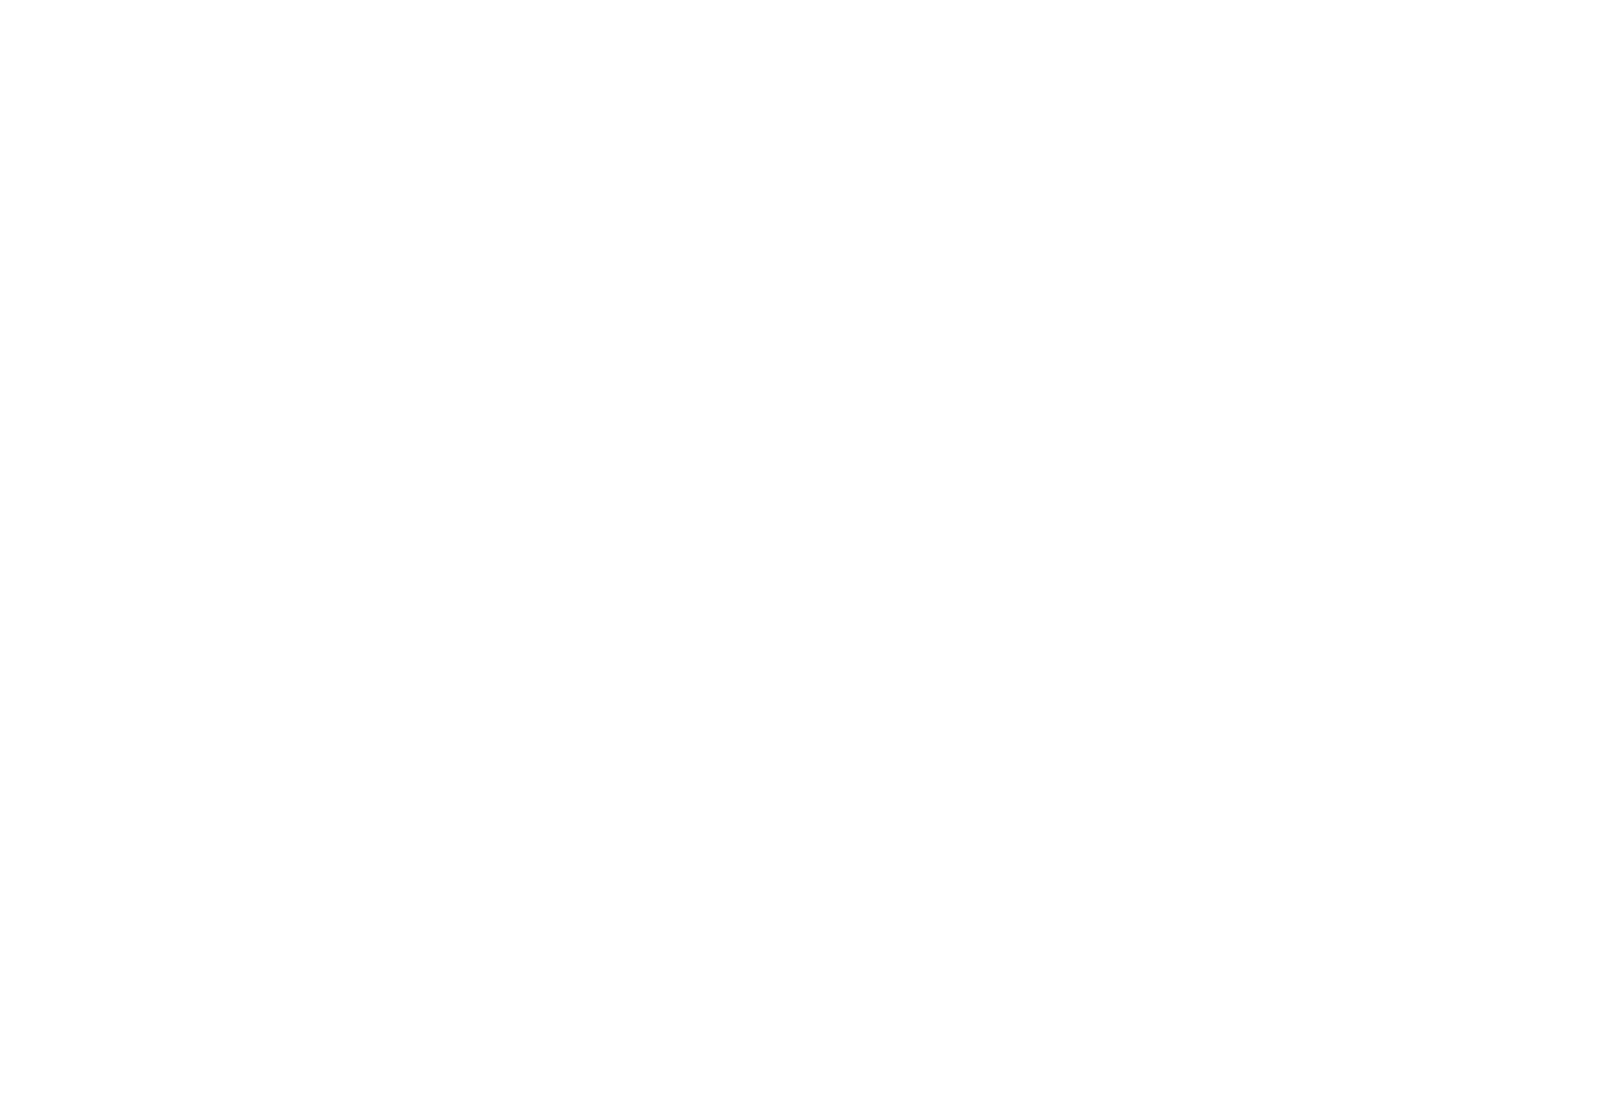

<IPython.core.display.Javascript object>


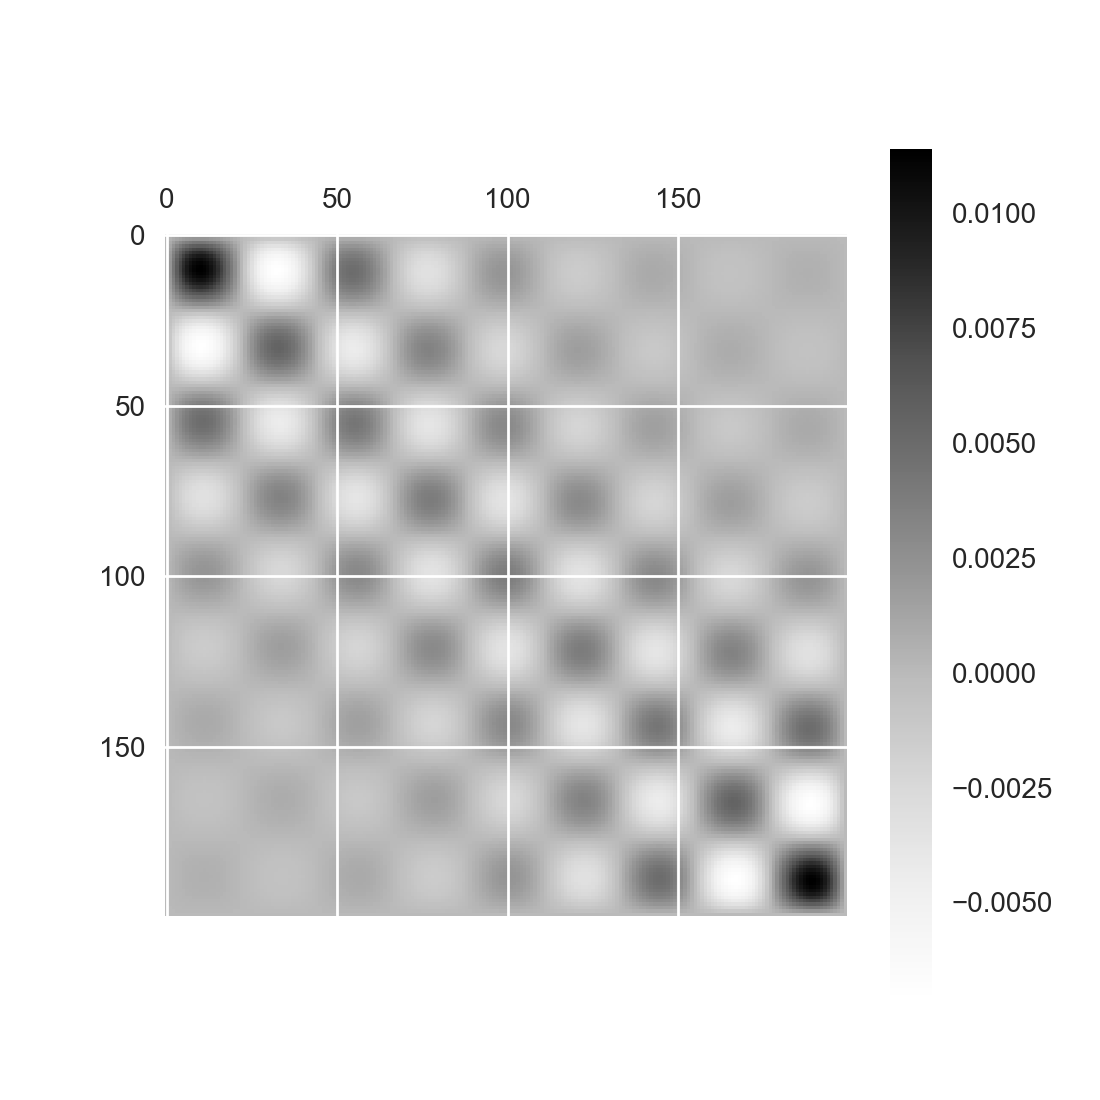

In [112]:
fig = plt.figure()
plt.matshow(cov_denoised)
plt.colorbar()

<IPython.core.display.Javascript object>


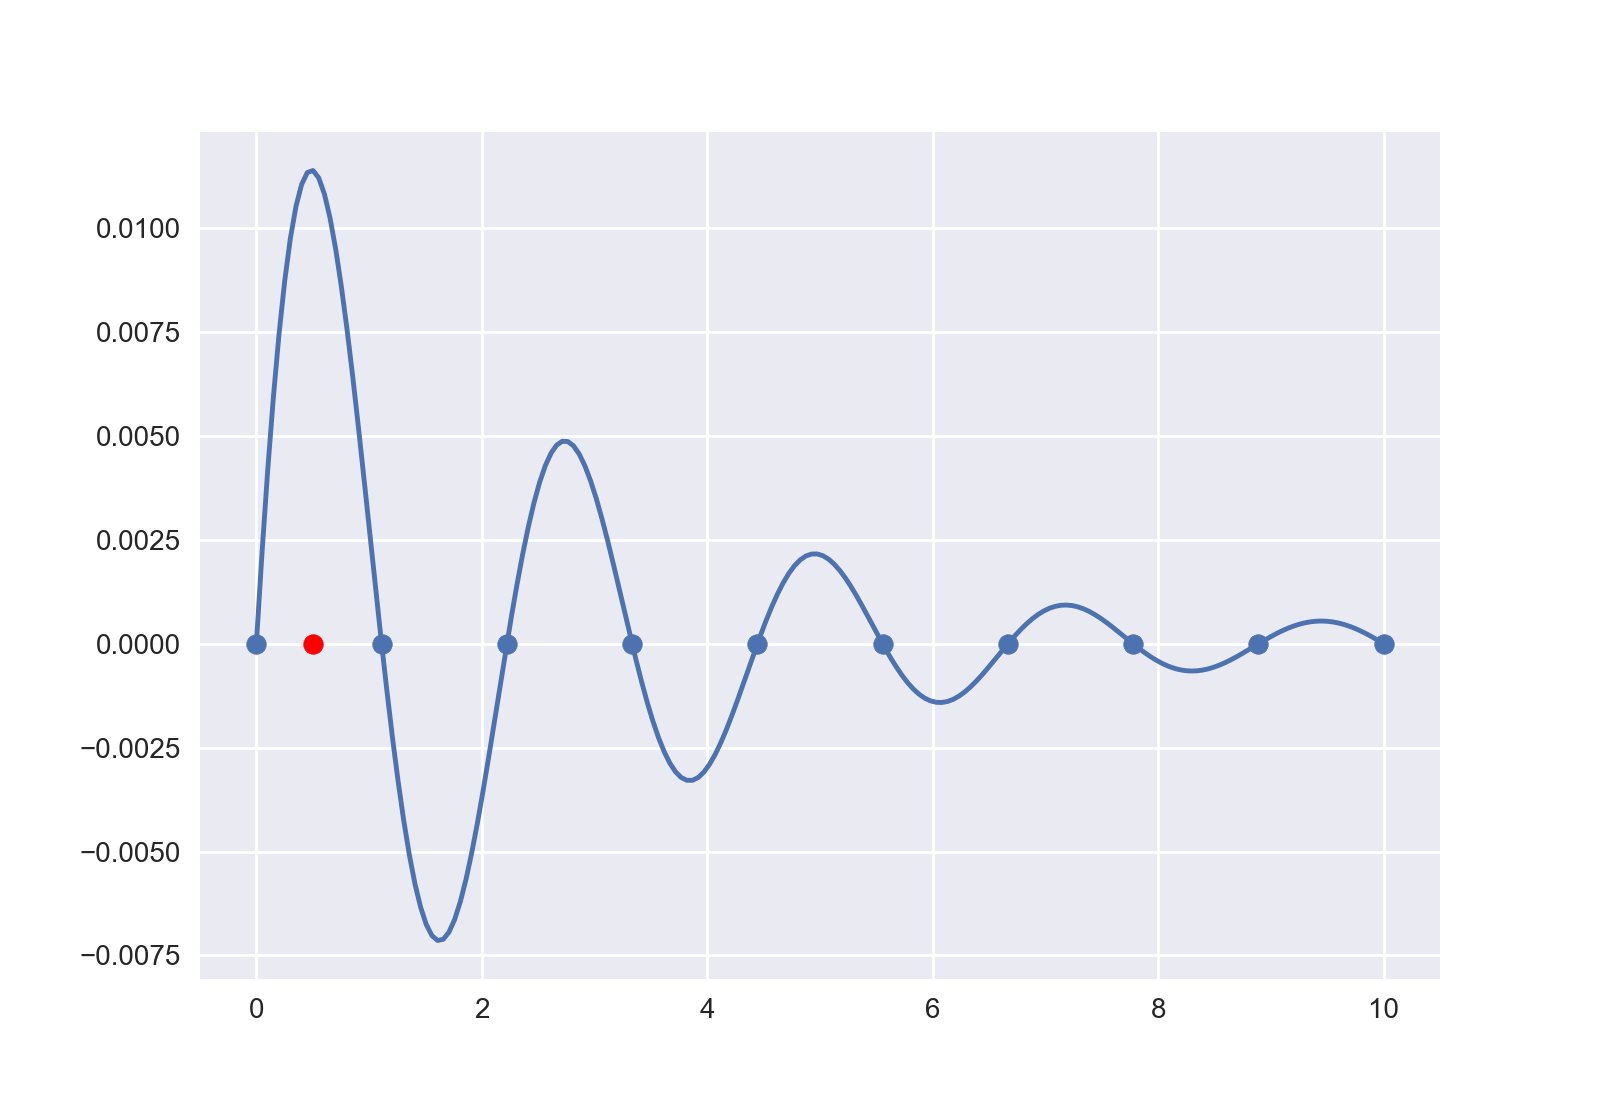

In [116]:
plt.figure()
plt.plot(T_sur,cov_denoised[10])
plt.scatter([T_sur[10]],[0],c='r')
plt.scatter(T_obs,np.zeros_like(T_obs))
plt.show()

<IPython.core.display.Javascript object>


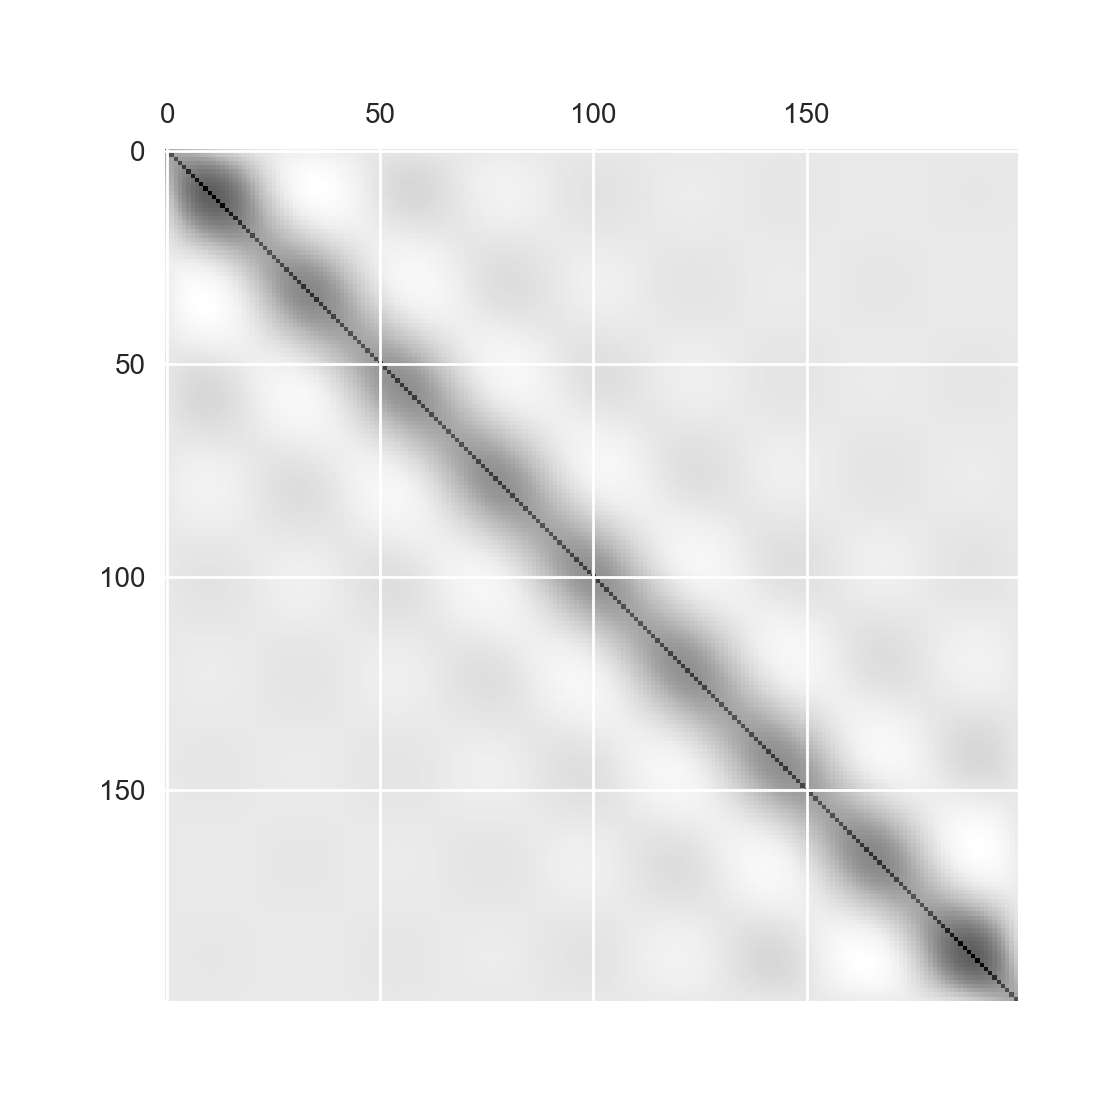

In [117]:
plt.matshow(cov)

<IPython.core.display.Javascript object>


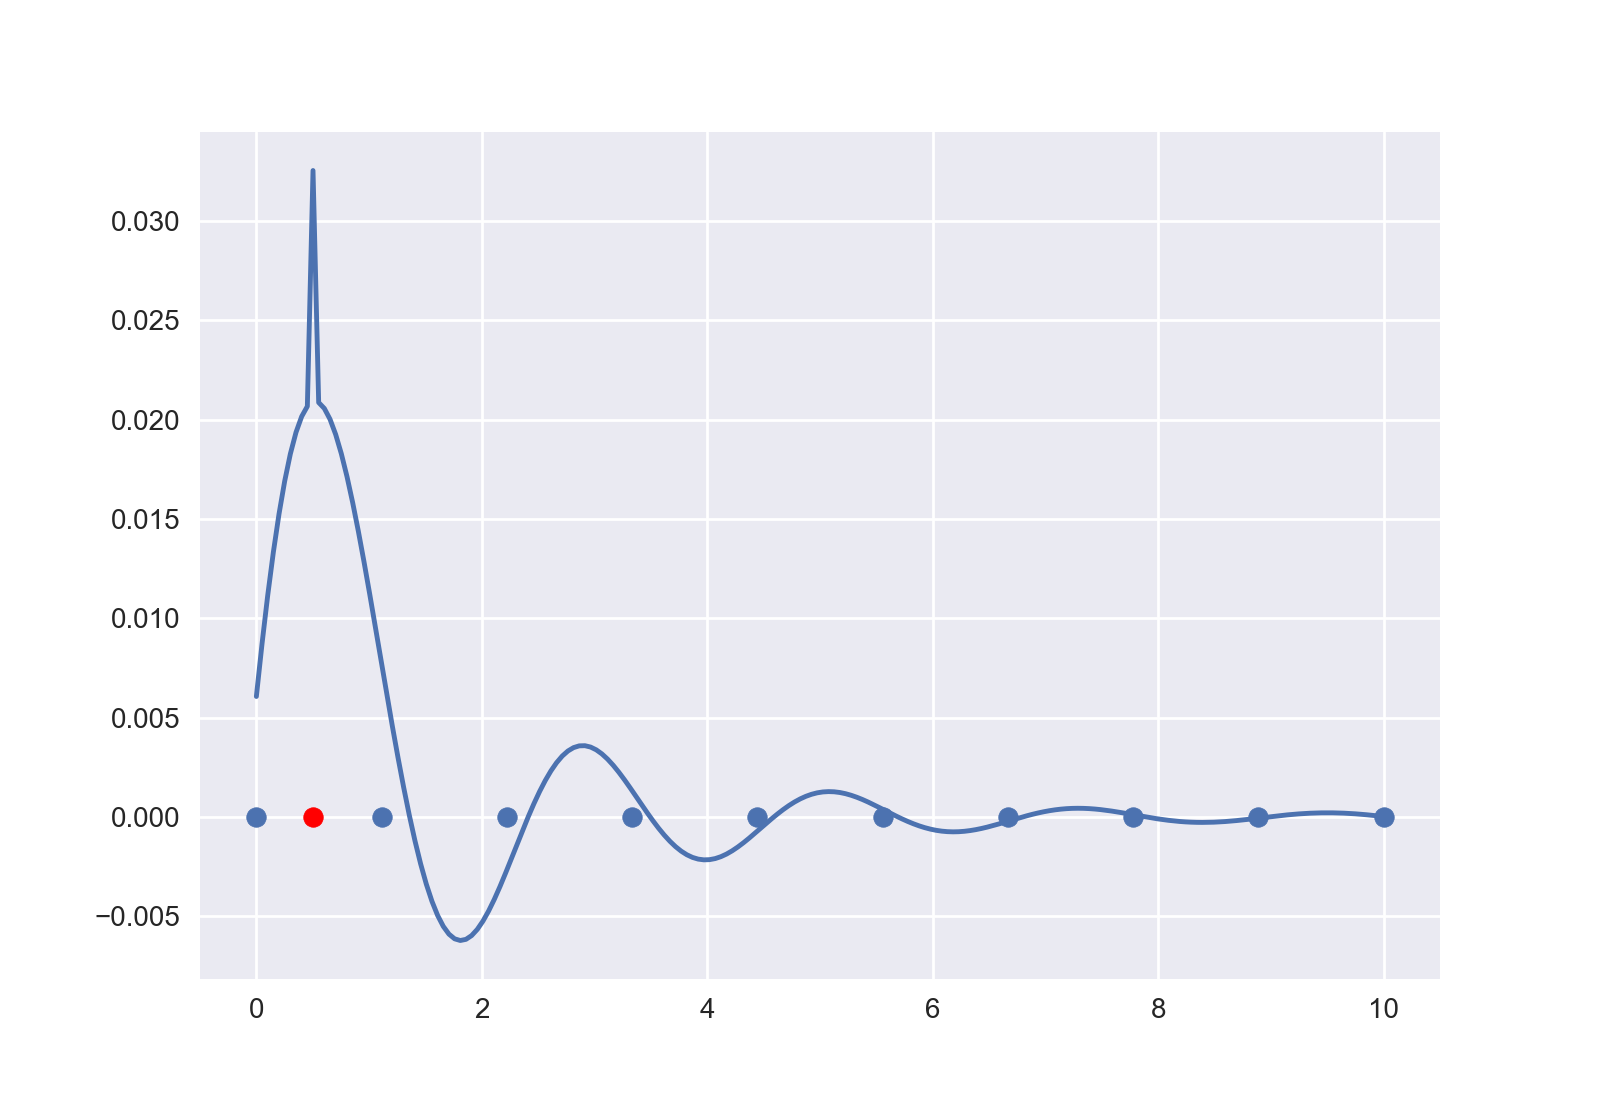

In [118]:
plt.figure()
plt.plot(T_sur,cov[10])
plt.scatter([T_sur[10]],[0],c='r')
plt.scatter(T_obs,np.zeros_like(T_obs))
plt.show()

In [119]:
cov_inv = la.inv(cov)

<IPython.core.display.Javascript object>


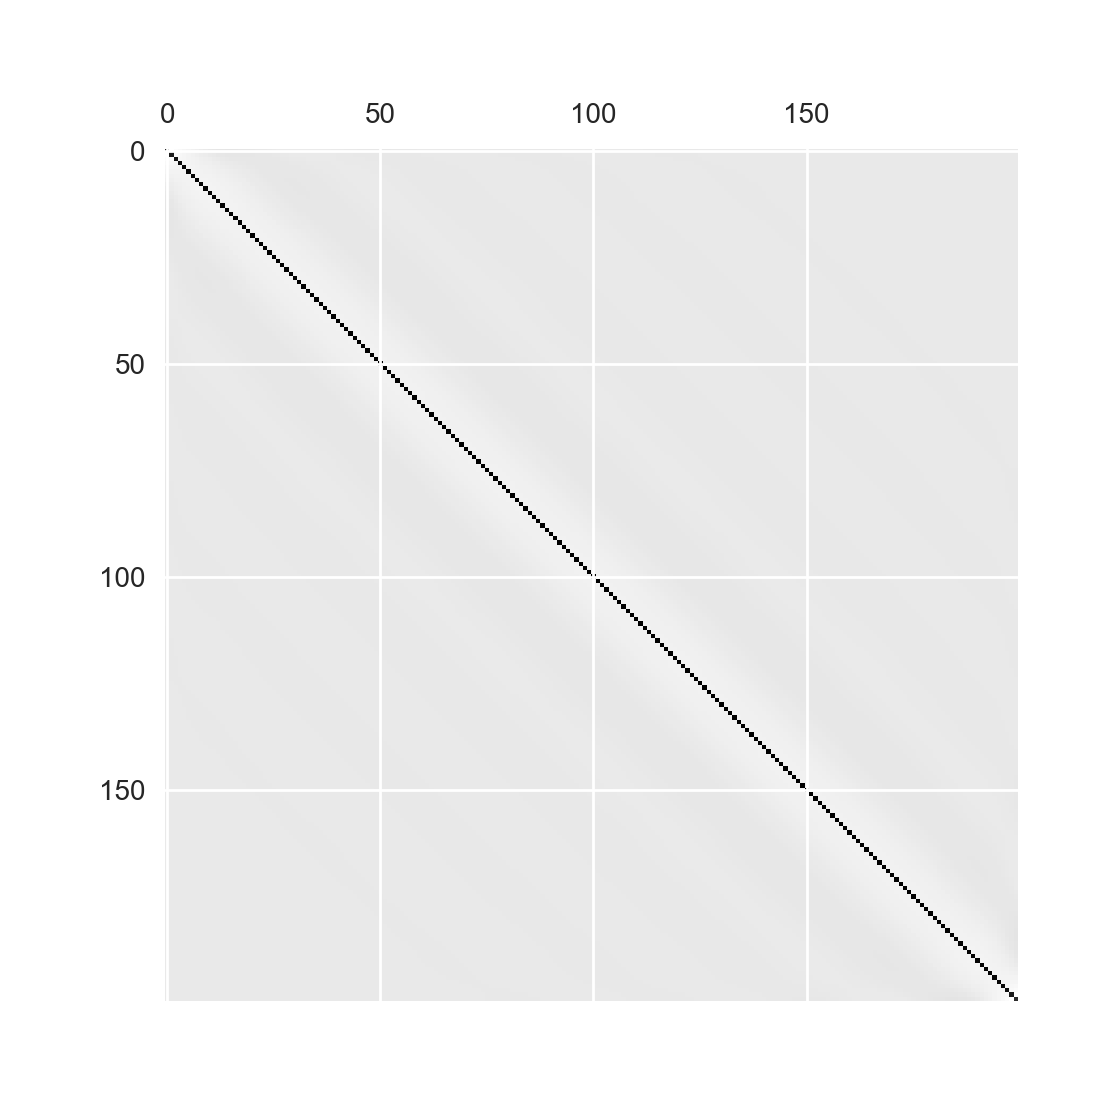

In [120]:
plt.matshow(cov_inv)

In [122]:
np.linalg.cond(cov)

31.083164177687816

In [123]:
np.linalg.cond(cov_denoised)

8.217939328703582e+16